In [1]:
from fastcore.all import *
from transformers import AutoModel
from fastprogress import progress_bar
from IPython.display import Markdown
import numpy as np, polars as pl, umap, hdbscan, plotly.express as px

# Clustering

## Dataset

In [2]:
path = Path('06_clustering')
path.mkdir(exist_ok=True)

In [3]:
path_data = path/'main.csv'
if path_data.exists():
    df_raw = pl.read_csv(path_data, infer_schema_length=10000)
else:
    df_raw = pl.read_csv('hf://datasets/somosnlp/RecetasDeLaAbuela/main.csv', infer_schema_length=10000)
    df_raw.write_csv(path_data)
df_raw.shape

(20236, 14)

In [4]:
print(df_raw.columns)

['Id', 'Nombre', 'URL', 'Ingredientes', 'Pasos', 'Pais', 'Duracion', 'Categoria', 'Contexto', 'Valoracion y Votos', 'Comensales', 'Tiempo', 'Dificultad', 'Valor nutricional']


In [5]:
df_raw.head(2)

Id,Nombre,URL,Ingredientes,Pasos,Pais,Duracion,Categoria,Contexto,Valoracion y Votos,Comensales,Tiempo,Dificultad,Valor nutricional
i64,str,str,str,str,str,str,str,str,str,str,str,str,str
1,"""Tacos Dorados de Papa""","""https://www.mexicoenmicocina.c…","""½ taza de cilantro finamente p…","""Pon las papas enteras en una o…","""MEX""","""01:00""","""vegetarianos""",null,null,"""6""",null,null,"""Alto en calorías, Alto en gras…"
2,"""Ensalada de Chayotes""","""https://www.mexicoenmicocina.c…","""½ cucharadita sal, ¼ cucharadi…","""Coloca los chayotes en una cac…","""MEX""","""00:25""","""vegetarianos""",null,null,"""4""",null,null,"""Bajo en calorías, Sin grasa, A…"


In [6]:
df = (
    df_raw
    .rename(lambda s: s.lower().replace(' ','_'))
    .select(
        'nombre', 'pais', 'categoria', 'pasos',
        (
            'Receta: ' + pl.col.nombre
            + '\nPais: ' + pl.col.pais
            + '\nNutricion: ' + pl.col.valor_nutricional
            + '\n\nIngredientes:\n' + pl.col.ingredientes
            # Para efectos de la demo no vamos a considerar los "pasos" para no hacer tan largo el texto
            # + '\n\nPasos:\n' + pl.col.pasos 
        )
        .str.replace_all('[\\[\\]\']', '')
        .alias('text')
    )
    .drop_nulls()
)
print(df.shape)
df.head(3)

(10758, 5)


nombre,pais,categoria,pasos,text
str,str,str,str,str
"""Tacos Dorados de Papa""","""MEX""","""vegetarianos""","""Pon las papas enteras en una o…","""Receta: Tacos Dorados de Papa …"
"""Ensalada de Chayotes""","""MEX""","""vegetarianos""","""Coloca los chayotes en una cac…","""Receta: Ensalada de Chayotes P…"
"""Huevos a la Mexicana""","""MEX""","""vegetarianos""","""Calienta el aceite en una sart…","""Receta: Huevos a la Mexicana P…"


In [7]:
print('\n==============\n'.join(df['text'].sample(3)))

Receta: croquetas de champinones
Pais: ESP
Nutricion: Bajo en calorías, Sin grasa, Alto en grasas reducidas o con menos grasas.

Ingredientes:
200 gramos de champiñones, 1 diente de ajos, 1 puñado de perejil, 50 gramos de mantequilla, 50 gramos de harina de trigo, 500 mililitros de leche, 1 pizca de sal, 1 vaso de aceite para freír, 2 huevos, 1 paquete de pan rallado, 1 pizca de pimienta o nuez moscada
Receta: ensalada de ave
Pais: ARG
Nutricion: Bajo en calorías, Sin grasa, Alto en fibra

Ingredientes:
1 unidad de Pollo chico cocido y desmenuzado, 3 cucharadas soperas de Apio picado, 3 unidades de Patatas cocidas cortadas en cubitos, 3 unidades de Zanahorias ralladas gruesas, 1 lata de Choclo en granos, 1 unidad de Ají cortado en tiritas, 1 lata de Arvejas, 1 taza de Mayonesa
Receta: tarta de hojaldre y manzana
Pais: ESP
Nutricion: Alto en calorías, Alto en grasas, Alto en azúcar

Ingredientes:
1 lámina de Hojaldre, 2 Manzanas rojas o verdes, 1 cucharada sopera de Mantequilla, 2 cucha

In [8]:
df['text'].str.len_chars().describe()

statistic,value
str,f64
"""count""",10758.0
"""null_count""",0.0
"""mean""",360.38483
"""std""",114.692955
"""min""",126.0
"""25%""",282.0
"""50%""",342.0
"""75%""",417.0
"""max""",1320.0


## Embeddings

In [9]:
model = AutoModel.from_pretrained('jinaai/jina-embeddings-v3', trust_remote_code=True).cuda()

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

In [10]:
sample = df.sample()['text'][0]
print(sample)

Receta: pastel de calabaza salado
Pais: ESP
Nutricion: Alto en grasas, Alto en calorías, Sin sodio

Ingredientes:
1 lámina de masa de hojaldre, 300 gramos de calabaza, 2 trozos de huevos, 50 gramos de jamón, beicon..., 50 gramos de queso mozzarella rallado, 100 mililitros de crema de leche o nata, 1 pizca de pimienta, 1 pizca de sal


In [11]:
model.encode(sample, truncate_dim=128, task='separation')[:20]

array([ 0.08525343, -0.03933235,  0.14436632,  0.08090241,  0.03779804,
        0.00615971, -0.05091245,  0.19336522, -0.08328953,  0.11938442,
       -0.09427942,  0.08579268, -0.24268135, -0.17504185, -0.21410418,
       -0.13341525, -0.26240912,  0.12914257,  0.00692349, -0.03045454],
      dtype=float32)

In [12]:
path_embs = path/'embs.npy'
bs = 256

if path_embs.exists():
    embs = np.load(path_embs)
else:
    embs = []
    for b in progress_bar(L(chunked(df['text'], bs))):
        embs.append(model.encode(b, truncate_dim=128, task='separation'))
        
    embs = np.concatenate(embs)
    np.save(path_embs, embs)
embs.shape

(10758, 128)

## Clustering

In [13]:
%%time
reducer = umap.UMAP(n_components=2, metric='cosine').fit(embs)
reducer.embedding_.shape

CPU times: user 26.3 s, sys: 1.12 s, total: 27.4 s
Wall time: 11.5 s


(10758, 2)

In [37]:
hdb = hdbscan.HDBSCAN(min_cluster_size=80).fit(reducer.embedding_)
f'# clusters: {hdb.labels_.max()+1}'

/home/renato/github/pucp_bootcamp_202401/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/renato/github/pucp_bootcamp_202401/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



'# clusters: 19'

In [38]:
df_clusters = df.with_columns(
    x=reducer.embedding_[:,0], y=reducer.embedding_[:,1],
    cluster=pl.Series(hdb.labels_).replace(-1, None),
)
df_clusters.head(2)

nombre,pais,categoria,pasos,text,x,y,cluster
str,str,str,str,str,f32,f32,i64
"""Tacos Dorados de Papa""","""MEX""","""vegetarianos""","""Pon las papas enteras en una o…","""Receta: Tacos Dorados de Papa …",12.988224,4.538222,13
"""Ensalada de Chayotes""","""MEX""","""vegetarianos""","""Coloca los chayotes en una cac…","""Receta: Ensalada de Chayotes P…",12.161795,5.43498,null


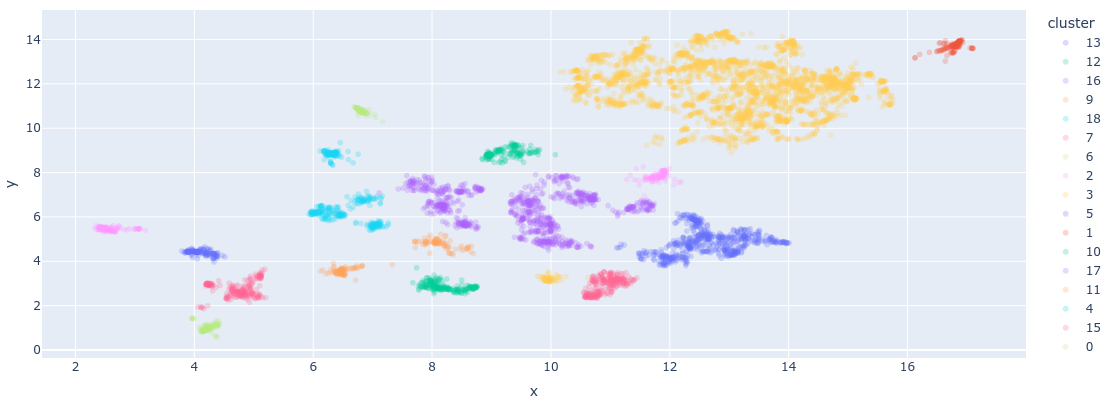

In [39]:
fig = px.scatter(
    df_clusters.with_columns(pl.col.cluster.cast(str)),
    x='x', y='y', color='cluster', hover_data=['nombre','pais','categoria','cluster'],
    opacity=0.25, width=1000, height=400,
)
fig.update_layout(margin=dict(l=0, r=0, t=10, b=0))
fig.show()

## Label clusters

In [40]:
from google import genai

In [41]:
client = genai.Client()

In [42]:
prompt_template = '''\
<asistente>
Eres un asistente de IA especializado en categorizar recetas de cocina. Se te brindarán ejemplos de un grupo \
de recetas, analízalas para responder la pregunta del usuario.
</asistente>

<recetas>
{examples}
</recetas>

Usa 3 palabras para categorizar las recetas brindadas. La respuesta sólo debe contener las 3 palabras \
separadas por coma. Por ejemplo: "categoria1, categoria2, categoria3".'''

In [43]:
df_clusters[0]

nombre,pais,categoria,pasos,text,x,y,cluster
str,str,str,str,str,f32,f32,i64
"""Tacos Dorados de Papa""","""MEX""","""vegetarianos""","""Pon las papas enteras en una o…","""Receta: Tacos Dorados de Papa …",12.988224,4.538222,13


In [45]:
# Get cluster samples
n_samples = 5

def merge_examples(examples):
    example_template = '<receta{i:02d}>\n{content}\n</receta{i:02d}>'
    examples = '\n\n'.join([example_template.format(i=i+1, content=o) for i,o in enumerate(examples)])
    return prompt_template.format(examples=examples)

df_samples = (
    df_clusters
    .filter(pl.col.cluster!=-1)
    .group_by('cluster')
    .agg(pl.struct('nombre', 'pais', 'categoria', 'text').sample(n_samples).alias('x'))
    .select(
        'cluster',
        *[pl.col.x.list.eval(pl.element().struct.field(o)).alias(o)
          for o in ('nombre','pais','categoria','text')]
    )
    .with_columns(pl.col.text.map_elements(merge_examples, return_dtype=pl.String))
    .with_columns(pl.col.text.str.len_chars().alias('chars'))
    .sort('cluster')
)
df_samples

cluster,nombre,pais,categoria,text,chars
i64,list[str],list[str],list[str],str,u32
0,"[""pizza de varios sabores"", ""masa de pizza con harina de arroz"", … ""pizza de champinones""]","[""ESP"", ""ESP"", … ""ESP""]","[""['Recetas al horno']"", ""['Recomendada para perder peso', 'Receta sin gluten', 'Recetas al horno']"", … ""['Recetas al horno']""]","""<asistente> Eres un asistente …",2129
1,"[""flan con dulce de leche y crema"", ""flan de huevo y leche condensada"", … ""tarta de galletas flan y chocolate sin horno""]","[""ARG"", ""ESP"", … ""ESP""]","[""['Receta sin sal', 'Recetas al horno']"", ""['Recetas al horno']"", … ""[]""]","""<asistente> Eres un asistente …",2428
2,"[""bacalao con almendras"", ""cocochas de bacalao al pil pil"", … ""bacalao con tomate frito de bote""]","[""ESP"", ""ESP"", … ""ESP""]","[""[]"", ""['Recetas españolas', 'Recetas vascas']"", … ""['Recetas españolas']""]","""<asistente> Eres un asistente …",2091
3,"[""gran terremoton"", ""chicha andina"", … ""zumo de melocoton y paraguayo""]","[""CHL"", ""VEN"", … ""PRY""]","[""['Recetas chilenas']"", ""['Recetas venezolanas']"", … ""['Recomendada para perder peso']""]","""<asistente> Eres un asistente …",2509
4,"[""berenjenas con patatas y pimientos"", ""pate de berenjena con miel"", … ""berenjenas rellenas de pollo al horno""]","[""ESP"", ""ESP"", … ""ESP""]","[""['Recomendada para perder peso']"", ""['Recomendada para veganos']"", … ""['Recetas al horno']""]","""<asistente> Eres un asistente …",2696
…,…,…,…,…,…
14,"[""entrecot con cebolla caramelizada"", ""redondo de ternera con guarnicion"", … ""fliletes de ternera con verduras salteadas""]","[""ESP"", ""ESP"", … ""ESP""]","[""['Recetas para Navidad']"", ""[]"", … ""[]""]","""<asistente> Eres un asistente …",2391
15,"[""lomo caramelizado"", ""higado encebollado sin vino"", … ""lengua a la vinagreta""]","[""ESP"", ""ESP"", … ""ARG""]","[""[]"", ""[]"", … ""[]""]","""<asistente> Eres un asistente …",2060
16,"[""sandwich light de bacalao"", ""empanadas de carne jugosas"", … ""bagel de surimi y bacon""]","[""ESP"", ""ARG"", … ""ESP""]","[""['Recomendada para perder peso']"", ""['Recetas al horno', 'Recetas argentinas']"", … ""[]""]","""<asistente> Eres un asistente …",2341


In [46]:
print(df_samples['text'][0])

<asistente>
Eres un asistente de IA especializado en categorizar recetas de cocina. Se te brindarán ejemplos de un grupo de recetas, analízalas para responder la pregunta del usuario.
</asistente>

<recetas>
<receta01>
Receta: pizza de varios sabores
Pais: ESP
Nutricion: Bajo en calorías, Sin grasa, Sin grasas trans

Ingredientes:
1 kilogramo de Harina, Sal, Levadura, Aceite de oliva virgen extra, Salsa, Jamon, Queso gouda, Champiñones, Maíz
</receta01>

<receta02>
Receta: masa de pizza con harina de arroz
Pais: ESP
Nutricion: Bajo en calorías, Sin grasa, Alto en fibra

Ingredientes:
300 gramos de harina de arroz, 1 cucharada postre de sal, 125 mililitros de agua natural, 13 gramos de levadura fresca o 4 gramos de levadura seca, 25 mililitros de aceite de oliva
</receta02>

<receta03>
Receta: base para pizza casera
Pais: ESP
Nutricion: Bajo en calorías, Sin grasa, Sin grasas trans

Ingredientes:
1 kilogramo de Harina, 30 gramos de Levadura en polvo, 2½ tazas de Agua tibia, 1 pizca de S

In [50]:
cluster_lbls = {}
for row in progress_bar(df_samples.iter_rows(named=True), total=len(df_samples)):
    r = client.models.generate_content(model='gemini-2.0-flash', contents=row['text'])
    cluster_lbls[row['cluster']] = r.text.strip()

In [57]:
cluster_lbls

{0: 'Pizza, Casera, España',
 1: 'Flan, Dulce, España',
 2: 'Bacalao, Español, Alto en grasa',
 3: 'Bebidas, Postres, Salsas',
 4: 'Berenjena, Saludable, Española',
 5: 'Salmón, Grasas, España',
 6: 'Camarones, Saludable, Internacional',
 7: 'Pescado, Marisco, Española',
 8: 'Huevos, Español, Fácil',
 9: 'Lentejas, España, Nutritivas',
 10: 'Arroz, Saludable, España',
 11: 'Garbanzos, Vegetariano, España',
 12: 'Calabaza, Grasas, España',
 13: 'Carnes, Salsas, Tradicionales',
 14: 'Ternera, Saludable, Variada',
 15: 'Carne, Nutrición, País',
 16: 'Saludable, Grasosa, Española',
 17: 'Saludable, Ligero, Español',
 18: 'España, Ensalada, Saludable'}

In [61]:
df_samples_lbls = df_samples.with_columns(pl.col.cluster.replace_strict(cluster_lbls).alias('labels'))
df_samples_lbls.head(2)

cluster,nombre,pais,categoria,text,chars,labels
i64,list[str],list[str],list[str],str,u32,str
0,"[""pizza de varios sabores"", ""masa de pizza con harina de arroz"", … ""pizza de champinones""]","[""ESP"", ""ESP"", … ""ESP""]","[""['Recetas al horno']"", ""['Recomendada para perder peso', 'Receta sin gluten', 'Recetas al horno']"", … ""['Recetas al horno']""]","""<asistente> Eres un asistente …",2129,"""Pizza, Casera, España"""
1,"[""flan con dulce de leche y crema"", ""flan de huevo y leche condensada"", … ""tarta de galletas flan y chocolate sin horno""]","[""ARG"", ""ESP"", … ""ESP""]","[""['Receta sin sal', 'Recetas al horno']"", ""['Recetas al horno']"", … ""[]""]","""<asistente> Eres un asistente …",2428,"""Flan, Dulce, España"""


In [64]:
for row in df_samples_lbls.iter_rows(named=True):
    res = f'Cluster: {row["cluster"]}\nLabel: {row["labels"]}\nRecetas:'
    for o in row['nombre']: res += f'\n- {o}'
    res += '\n'+'='*50
    print(res)

Cluster: 0
Label: Pizza, Casera, España
Recetas:
- pizza de varios sabores
- masa de pizza con harina de arroz
- base para pizza casera
- pizza de salami
- pizza de champinones
Cluster: 1
Label: Flan, Dulce, España
Recetas:
- flan con dulce de leche y crema
- flan de huevo y leche condensada
- empanadillas dulces rellenas de flan
- flan de turron
- tarta de galletas flan y chocolate sin horno
Cluster: 2
Label: Bacalao, Español, Alto en grasa
Recetas:
- bacalao con almendras
- cocochas de bacalao al pil pil
- bacalao a la vizcaina facil
- bacalao a la bilbaina
- bacalao con tomate frito de bote
Cluster: 3
Label: Bebidas, Postres, Salsas
Recetas:
- gran terremoton
- chicha andina
- tarta muerte por chocolate
- mermelada de aji dulce
- zumo de melocoton y paraguayo
Cluster: 4
Label: Berenjena, Saludable, Española
Recetas:
- berenjenas con patatas y pimientos
- pate de berenjena con miel
- berenjenas rellenas con gambas y jamon
- rollos vegetarianos de hinojo
- berenjenas rellenas de pollo

In [66]:
df_clusters_lbls = df_clusters.with_columns(pl.col.cluster.replace_strict(cluster_lbls).alias('labels'))
df_clusters_lbls.head(2)

nombre,pais,categoria,pasos,text,x,y,cluster,labels
str,str,str,str,str,f32,f32,i64,str
"""Tacos Dorados de Papa""","""MEX""","""vegetarianos""","""Pon las papas enteras en una o…","""Receta: Tacos Dorados de Papa …",12.988224,4.538222,13,"""Carnes, Salsas, Tradicionales"""
"""Ensalada de Chayotes""","""MEX""","""vegetarianos""","""Coloca los chayotes en una cac…","""Receta: Ensalada de Chayotes P…",12.161795,5.43498,null,null


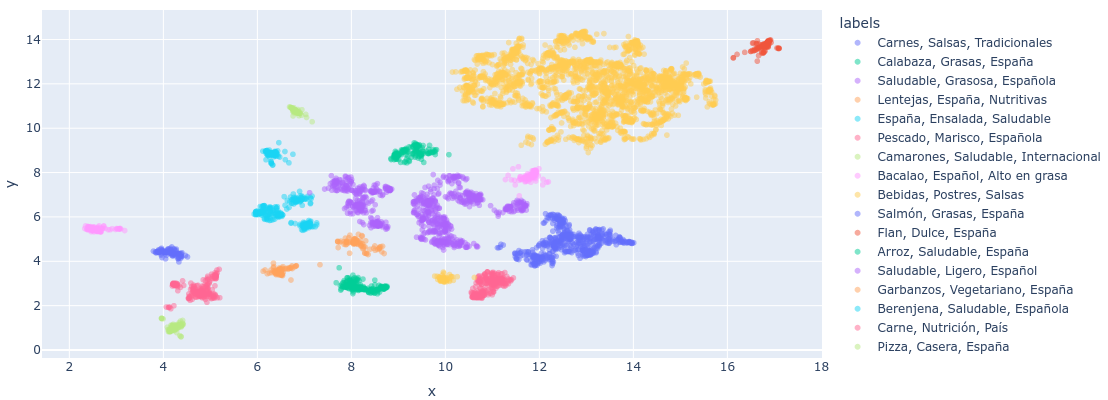

In [67]:
fig = px.scatter(
    df_clusters_lbls,
    x='x', y='y', color='labels', hover_data=['nombre','pais','categoria','cluster','labels'],
    opacity=0.5, width=1000, height=400,
)
fig.update_layout(margin=dict(l=0, r=0, t=10, b=0))
fig.show()